# ENGR-E 221 Intelligent Systems I Fall 2023

## Lab 12 Reinforcement learning - AI Gym

OpenAI Gym is a free Python toolkit that provides developers with an environment for developing and testing learning agents for deep learning models. It’s useful as a reinforcement learning agent, but it’s also adept at testing new learning agent ideas, running training simulations and speeding up the learning process for your algorithm.  

First we need to install AI Gym

## Part 1. Installing and Exploring AI Gym

In [1]:
!pip install gym

## Part 2. Cart Pole

In [2]:
import os
import gym
import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib qt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

env = gym.make("CartPole-v1",render_mode="rgb_array")

env.reset()
#environment.render()

plt.imshow(env.render() )
plt.show()
env.render()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

## Environment
What observations can be made about the environment?

In [3]:
obs, info = env.reset(seed=42)
print(obs)
#horizontal position (0.0 = center)
#velocity (positive means right)
#angle of the pole (0.0 = vertical)
#angular velocity (positive means clockwise)

plt.imshow(env.render() )
plt.show()

[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


## Actions
What actions are available in this environment?

In [4]:
env.action_space

# there are two things we can do - 
# accelerate the cart to the right (1)
# accelerate the cart to the left (0)

Discrete(2)

In [5]:
# Since the pole is leaning to the right, let's move the cart right to try and align the pole vertical
action = 1
obs,reward,done,truncated,info = env.step(action)
print(obs,reward,done,truncated,info)
plt.imshow(env.render() )
plt.show()
#obs the new observation
#reward 1.0 at every step no matter what so the goal is to keep the episode running for as long as possible
#done will be True when episode is over (pole tilts too much, if cart goes off screen or
      #after 200 steps - in this case, we won)
#truncated is True if the episdoe is interrupted early
#info is an environment-specific dictionary and may give extra info

[ 0.02727336  0.18847767  0.03625453 -0.26141977] 1.0 False False {}


C:\Users\Hamad\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [6]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle <0 else 1 

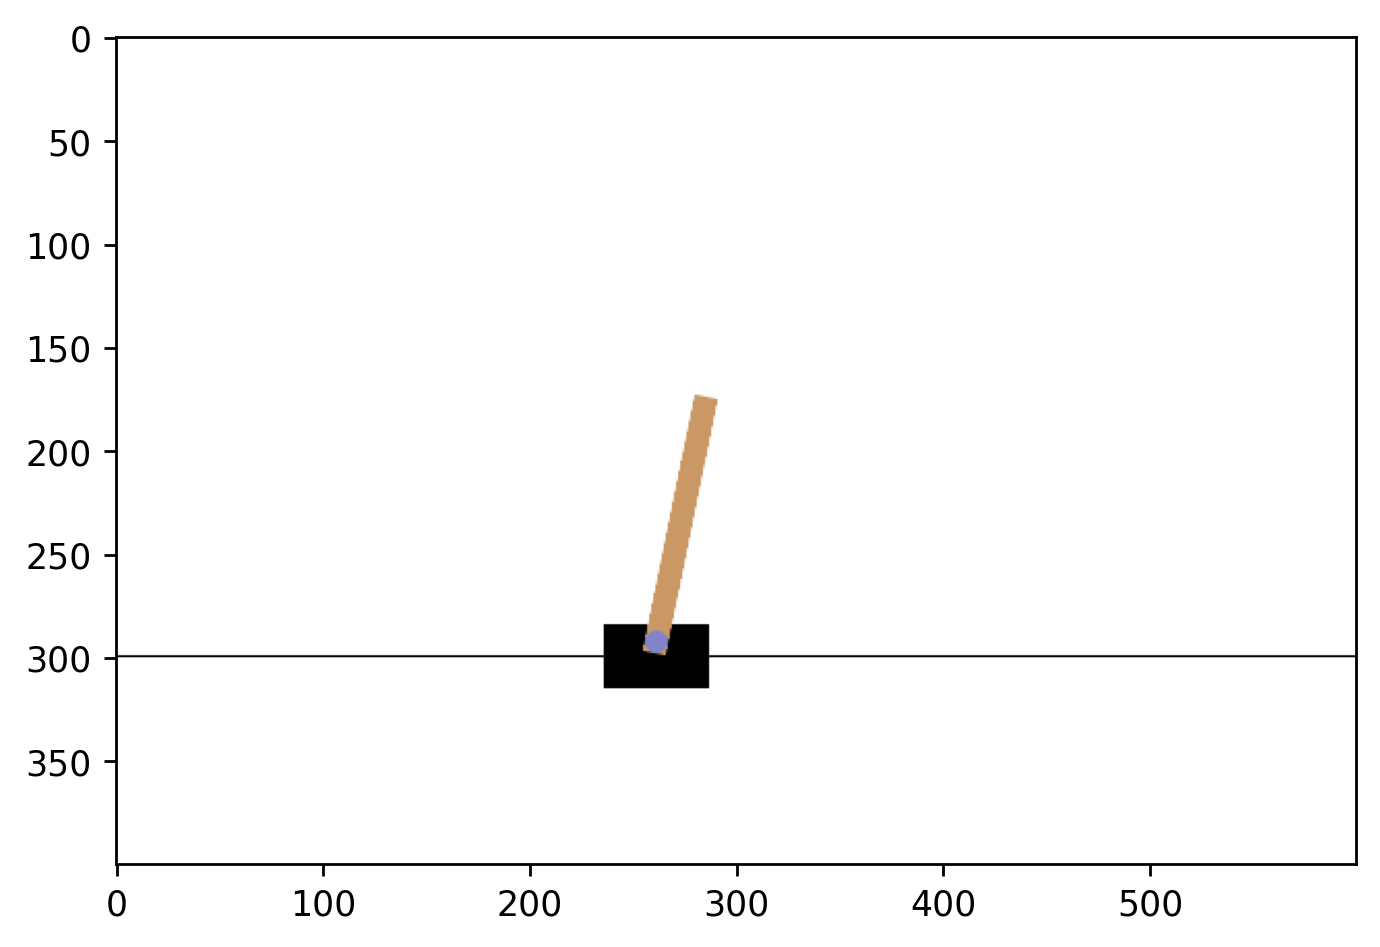

In [7]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env.reset()
img = plt.imshow(env.render()) # only call this once
#%matplotlib qt
for episode in range(10):
    env.reset()
    img = plt.imshow(env.render()) # only call this once
    episode_rewards =0
    obs,info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs,reward,done,truncated,info = env.step(action)
        if done or truncated:
            break
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = env.action_space.sample()
        env.step(action)

        

In [8]:
total = []
%matplotlib qt
for episode in range(500):
    episode_rewards =0
    obs,info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs,reward,done,truncated,info = env.step(action)
        #print(obs,reward,done,truncated,info)
        episode_rewards+=reward
        if done or truncated:
            break
    total.append(episode_rewards)
       
        

In [9]:
np.mean(total), np.std(total),min(total),max(total)

(41.698, 8.389445512070509, 24.0, 63.0)

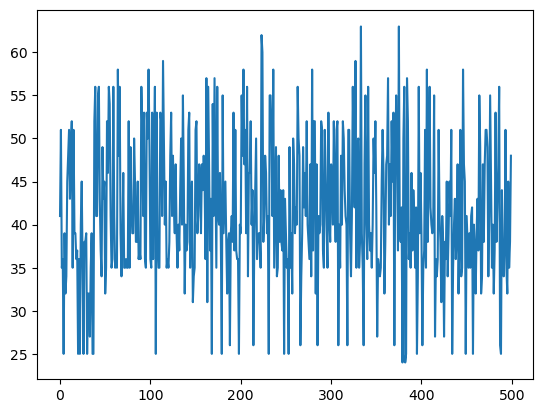

In [10]:
%matplotlib inline
plt.close("all")
plt.plot(total)
plt.show()
%matplotlib qt

# Q-learning

Convert Catpoles continues state space into discrete one. 

In [11]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np 
import time, math, random
from typing import Tuple

n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    """Convert continues state intro a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))


Initialise the Q value table with zeros. 

In [12]:
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape

(6, 12, 2)

Create a polict function,  uses the Q-table to and greedly selecting the highest Q value 

In [13]:
def policy( state : tuple ):
    """Choosing action based on epsilon-greedy policy"""
    return np.argmax(Q_table[state])


Update function 

In [14]:
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    """Temperal diffrence for updating Q-value of state-action pair"""
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

Decaying learning rate

In [15]:
# Adaptive learning of Learning Rate
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    """Decaying learning rate"""
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

Decaying exploration rate

In [16]:
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    """Decaying exploration rate"""
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

## Training

In [17]:
import warnings
warnings.filterwarnings('ignore')

n_episodes = 1000 
for e in range(n_episodes):
    
    # Siscretize state into buckets
    init_state = env.reset()
    cd , cv, a, pv = init_state[0]
    current_state, done = discretizer( cd , cv, a, pv), False
    
    while done==False:
        
        # policy action 
        action = policy(current_state) # exploit
        
        # insert random action
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore 
         
        # increment enviroment
        obs, reward, done, trun, info = env.step(action)
        new_state = discretizer(*obs)
        
        # Update Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state )
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
        current_state = new_state
        
        # Render the cartpole environment
        #env.render()
            

            
            

In [18]:
print(Q_table)

[[[  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[ 50.36314379  58.67149771]
  [ 28.5117054   53.7355307 ]
  [ 22.7881066   51.64813749]
  [  1.          41.94930516]
  [  0.          44.50720701]
  [  0.47886192  22.41070245]
  [  0.47886192   0.        ]
  [  0.           0.        ]
  [ 40.9484565    0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[199.25239381 106.39501925]
  [150.51174037 113.60887601]
  [328.53465922 130.50723641]
  [236.12875942 131.44383206]
  [374.83434147 181.38053782]
  [329.66563744 176.77219233]
  [388.27222179 335.63949101]
  [350.95957677 226.79109226]
  [281.77961977 390.91761674]
  [170

## Testing

In [19]:
import warnings
warnings.filterwarnings('ignore')

n_episodes = 1000 
steps = []
for e in range(n_episodes):
    
    # Siscretize state into buckets
    init_state = env.reset()
    cd , cv, a, pv = init_state[0]
    current_state, done = discretizer( cd , cv, a, pv), False
    epis_steps = 0
    
    while done==False:
        
        # policy action 
        action = policy(current_state) # exploit
        
        # insert random action
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore 
         
        # increment enviroment
        obs, reward, done, trun, info = env.step(action)
        new_state = discretizer(*obs)
        
        # Update Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state )
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
        current_state = new_state
        epis_steps+=1
    steps.append(epis_steps)

import matplotlib.pyplot as plt
plt.plot(steps)





CREDIT :

Sean Saito - vitoshacademy.com

https://www.vitoshacademy.com/python-balancing-cartpole-with-machine-learning/ 

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [20]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's write a small policy function that will use the neural net to get the probability of moving left, then let's use it to run one episode:

In [21]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)
    return int(np.random.rand() > left_proba)


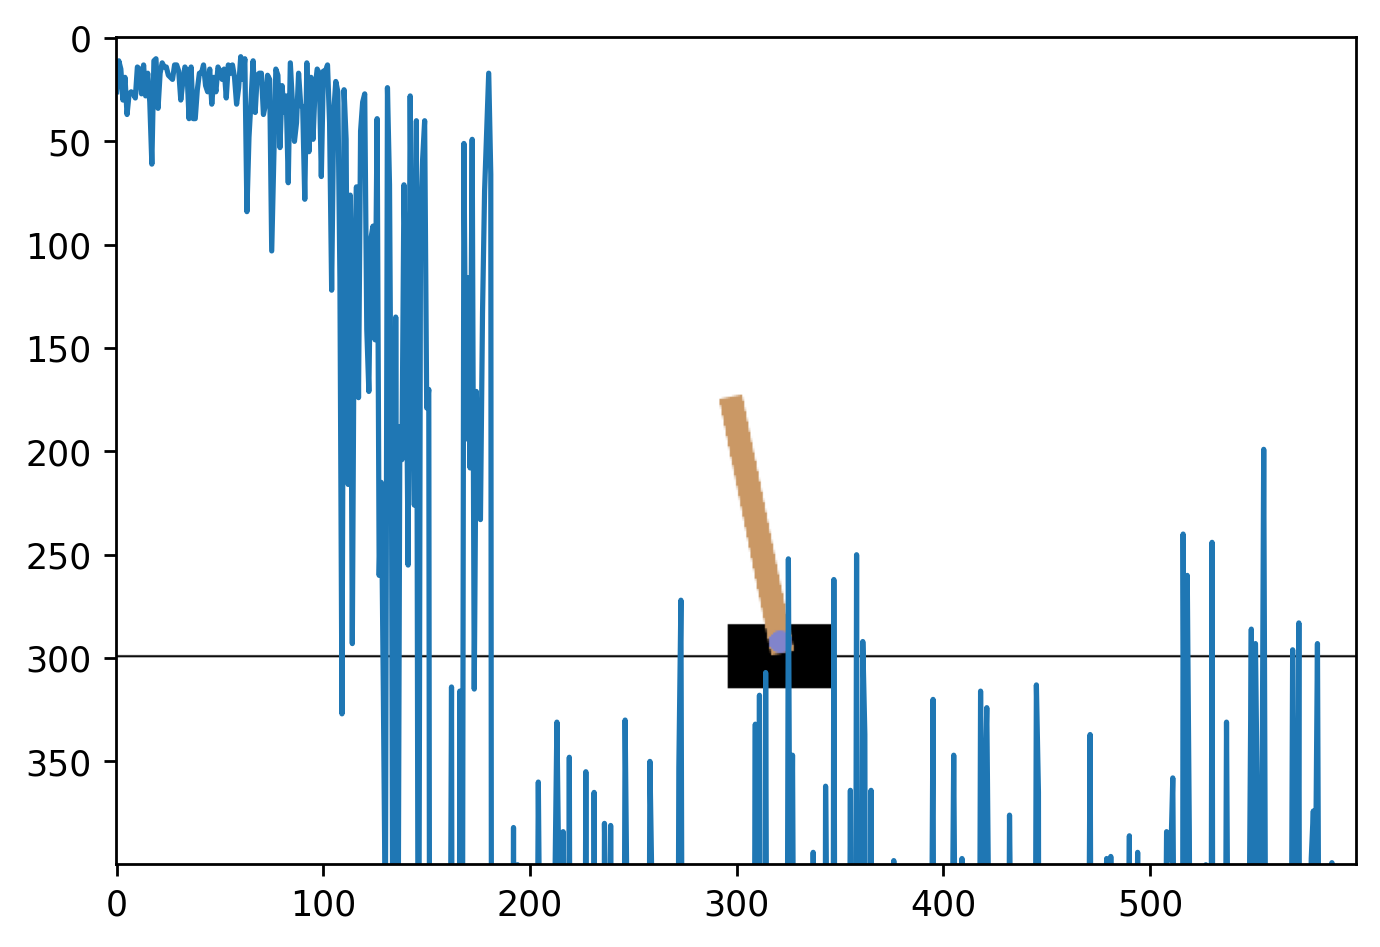

In [22]:
env.reset()
img = plt.imshow(env.render()) # only call this once
#%matplotlib qt
for episode in range(10):
    env.reset()
    img = plt.imshow(env.render()) # only call this once
    episode_rewards =0
    obs,info = env.reset(seed=episode)
    for step in range(200):
        action = pg_policy(obs)
        obs,reward,done,truncated,info = env.step(action)
        if done or truncated:
            break
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = env.action_space.sample()
        env.step(action)


22.932 13.458654316089703 8.0 99.0


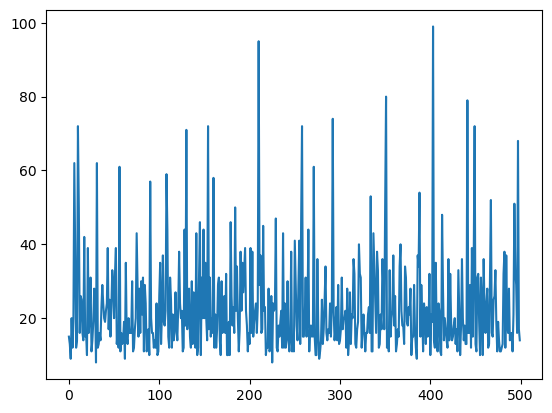

In [23]:
total = []
%matplotlib qt
for episode in range(500):
    episode_rewards =0
    obs,info = env.reset(seed=episode)
    for step in range(200):
        action = pg_policy(obs)
        obs,reward,done,truncated,info = env.step(action)
        #print(obs,reward,done,truncated,info)
        episode_rewards+=reward
        if done or truncated:
            break
    total.append(episode_rewards)
       
print(np.mean(total), np.std(total),min(total),max(total))

%matplotlib inline
plt.close("all")
plt.plot(total)
plt.show()
%matplotlib qt

Yeah... still not great. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

# Policy Gradients

To train this neural network we will need to define the target probabilities **y**. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions near positive rewards slightly more likely, while actions near negative rewards are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients. We will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be.

In [24]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [25]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [26]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [27]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [28]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [29]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [30]:
# extra code – let's create the neural net and reset the environment, for
#              reproducibility

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [31]:
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [32]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 196.0

## Part 3. Frozen Lake

In [33]:
import gym
import random
import numpy as np

#S F F F       (S: starting point, safe)
#F H F H       (F: frozen surface, safe)
#F F F H       (H: hole, stuck forever)
#H F F G       (G: goal, safe)

environment = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")
environment.reset()
environment.render()


#S     ◀️LEFT    🔽DOWN    ▶️RIGHT   🔼UP
#0     Q(0,◀️)   Q(0,🔽)   Q(0,▶️)   Q(0,🔼)
#1     Q(1,◀️)   Q(1,🔽)   Q(1,▶️)   Q(1,🔼)
#2     Q(2,◀️)   Q(2,🔽)   Q(2,▶️)   Q(2,🔼)
#...     ...       ...        ...       ...
#14    Q(14,◀️)  Q(14,🔽)  Q(14,▶️)  Q(14,🔼)
#G     Q(15,◀️)  Q(15,🔽)  Q(15,▶️)  Q(15,🔼)

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]

In [34]:
import os
import gym
import matplotlib.pyplot as plt
import time
%matplotlib qt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")
env.reset()
#environment.render()

plt.imshow(env.render() )
plt.show()

In [35]:

numberOfIterations=5
for i in range(numberOfIterations):
    randomAction= env.action_space.sample()
    returnValue=env.step(randomAction)
    plt.imshow(env.render() )
    plt.show()
    print('Iteration: {} and action {}'.format(i+1,randomAction))
    time.sleep(2)
    if returnValue[2]:
        break

env.close()



Iteration: 1 and action 0
Iteration: 2 and action 2
Iteration: 3 and action 3
Iteration: 4 and action 3
Iteration: 5 and action 2


## BlackJack with Q-learning

Blackjack is one of the most popular casino card games that is also infamous for being beatable under certain conditions. This version of the game uses an infinite deck (we draw the cards with replacement), so counting cards won’t be a viable strategy in our simulated game. Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

Objective: To win, your card sum should be greater than the dealers without exceeding 21.

Actions: Agents can pick between two actions:
stand (0): the player takes no more cards

hit (1): the player will be given another card, however the player could get over 21 and bust

Approach: To solve this environment by yourself, you can pick your favorite discrete RL algorithm. The presented solution uses Q-learning (a model-free RL algorithm).

Adapted from tutorial at https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/

### Creating and Observing the Environment
First of all, we call env.reset() to start an episode. This function resets the environment to a starting position and returns an initial observation. We usually also set done = False. This variable will be useful later to check if a game is terminated (i.e., the player wins or loses).

In [36]:
import gym
import random
import numpy as np
from collections import defaultdict

import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True)

## Other possible environment configurations are:
#env = gym.make('Blackjack-v1', natural=True, sab=False)
## Whether to give an additional reward for starting with a natural blackjack, 
##i.e. starting with an ace and ten (sum is 21).

#env = gym.make('Blackjack-v1', natural=False, sab=False)
## Whether to follow the exact rules outlined in the book by Sutton and Barto. 
##If `sab` is `True`, the keyword argument `natural` will be ignored.

# reset the environment to get the first observation
done = False
observation, info = env.reset()
print(observation)
print(info)

(11, 2, False)
{}


## Executing an action
After receiving our first observation, we are only going to use the env.step(action) function to interact with the environment. This function takes an action as input and executes it in the environment. Because that action changes the state of the environment, it returns four useful variables to us. These are:

next_state: This is the observation that the agent will receive after taking the action.

reward: This is the reward that the agent will receive after taking the action.

terminated: This is a boolean variable that indicates whether or not the environment has terminated.

truncated: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.

info: This is a dictionary that might contain additional information about the environment.

The next_state, reward, terminated and truncated variables are self-explanatory, but the info variable requires some additional explanation. This variable contains a dictionary that might have some extra information about the environment, but in the Blackjack-v1 environment you can ignore it. For example in Atari environments the info dictionary has a ale.lives key that tells us how many lives the agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call env.render() in your training loop because rendering slows down training by a lot. Rather try to build an extra loop to evaluate and showcase the agent after training.

In [37]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)
print(observation, reward, terminated, truncated, info)

# observation=(21, 7, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

(11, 2, False) -1.0 True False {}


## Building an agent
Let’s build a Q-learning agent to solve Blackjack-v1! We’ll need some functions for picking an action and updating the agents action values. To ensure that the agents explores the environment, one possible solution is the epsilon-greedy strategy, where we pick a random action with the percentage epsilon and the greedy action (currently valued as the best) 1 - epsilon.

In [38]:
class BlackjackAgent:
    def __init__(self,learning_rate,initial_epsilon,epsilon_decay,final_epsilon,discount_factor):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.discount_factor = 0.95
        self.training_error = []

    def get_action(self, obs):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(self,obs,action,reward,terminated,next_obs,):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

To train the agent, we will let the agent play one episode (one complete game is called an episode) at a time and then update it’s Q-values after each episode. The agent will have to experience a lot of episodes to explore the environment sufficiently.

Now we should be ready to build the training loop.

In [39]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor = 0.95
)

Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent. If you want to converge to the optimal policy, try increasing the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).

In [40]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:08<00:00, 11845.96it/s]


# Visualizing the Training

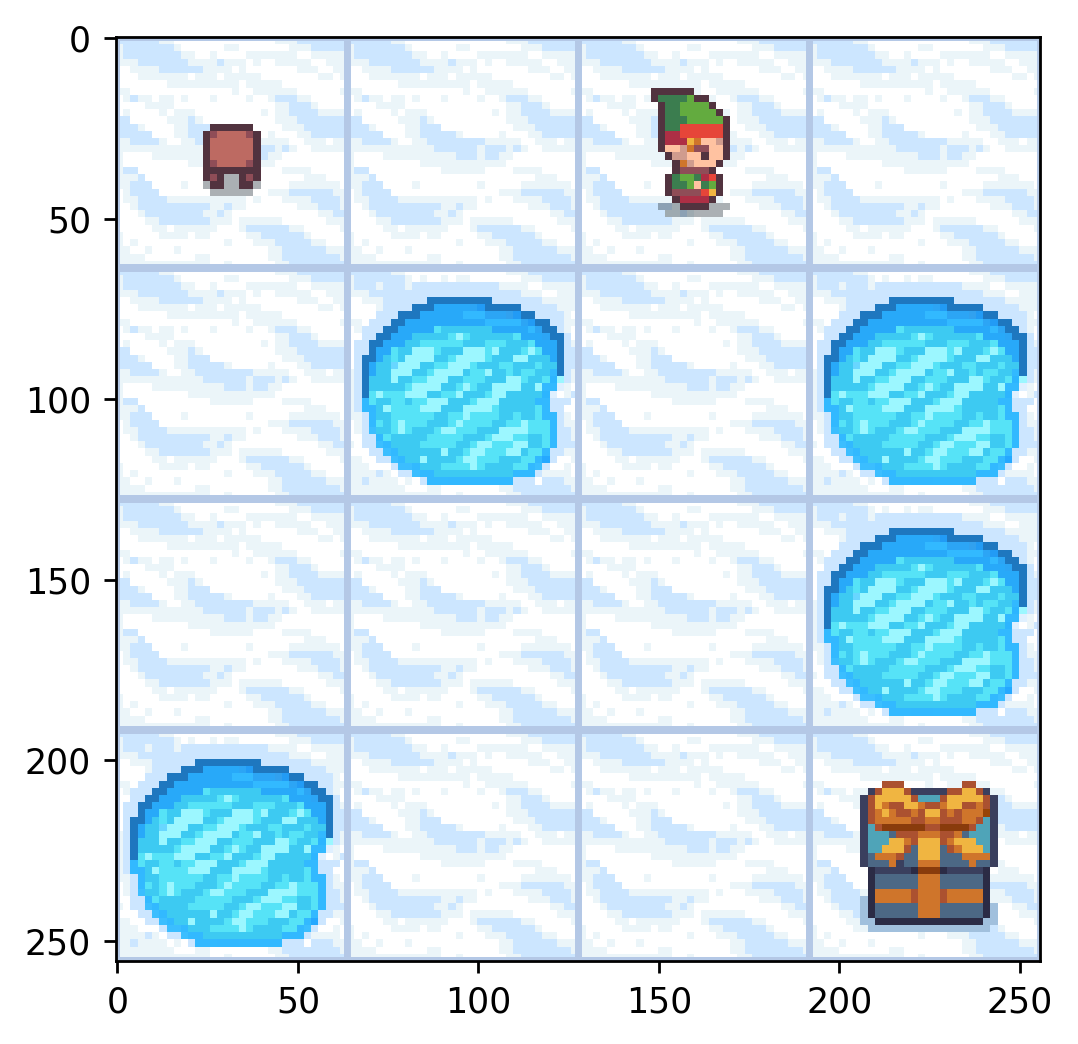

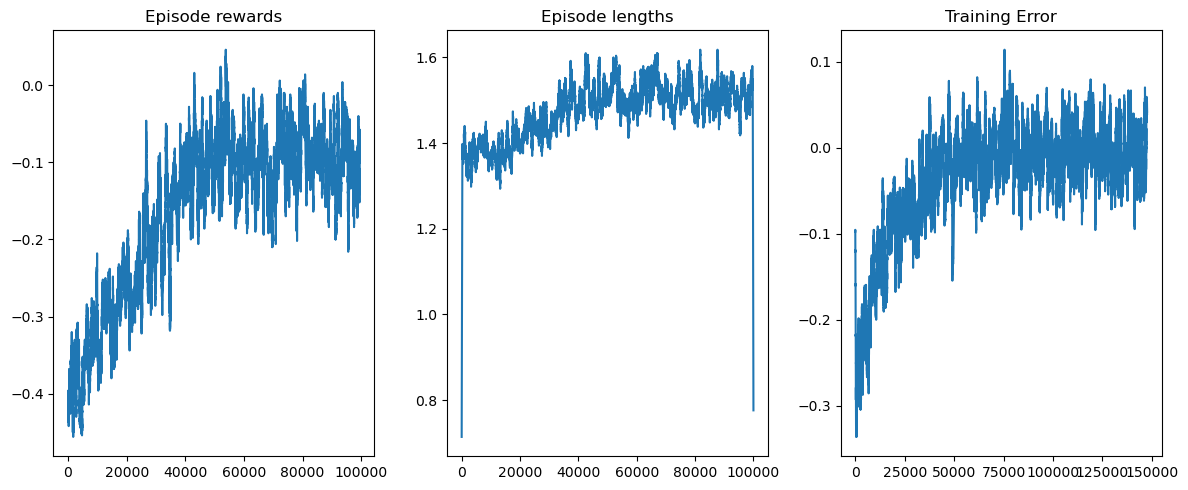

In [41]:
%matplotlib inline
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

# Visualizing the Policy

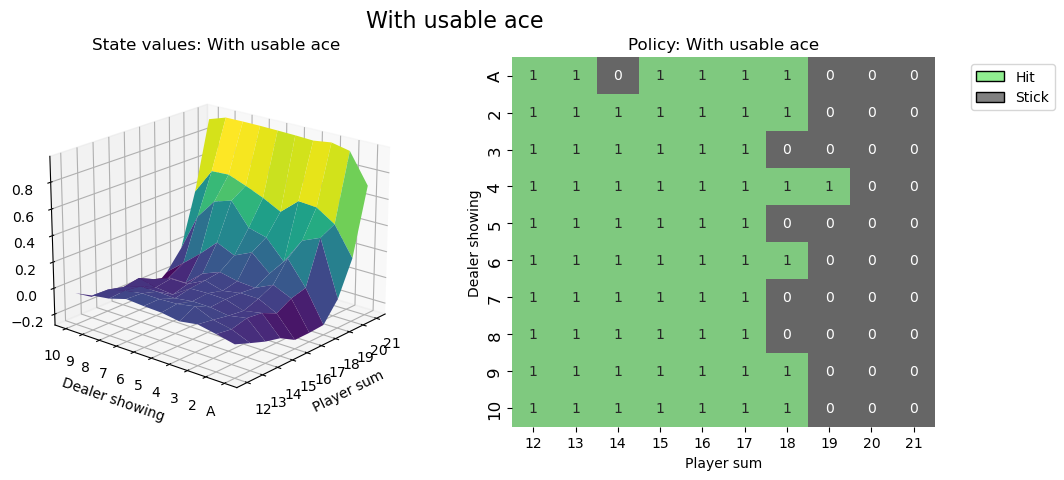

In [42]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

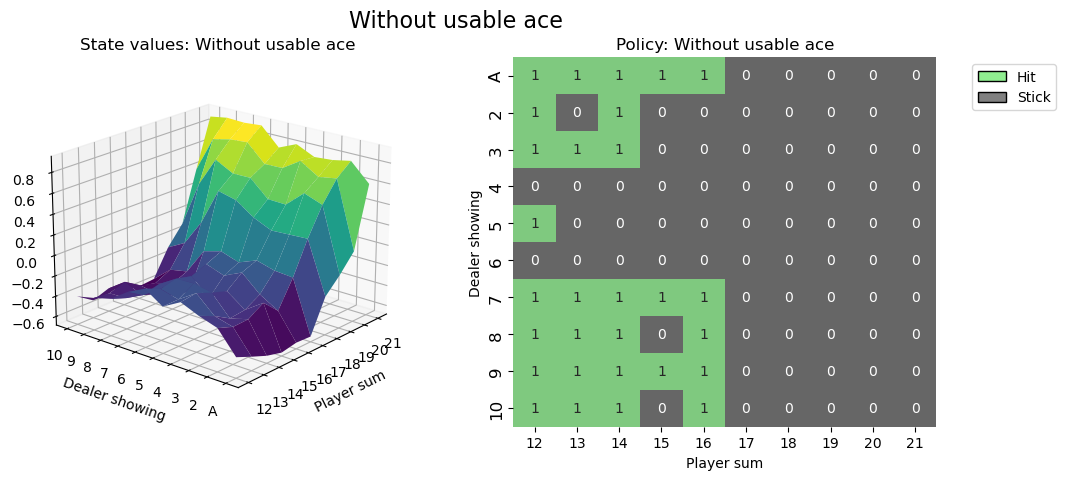

In [43]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [44]:
env.close()